In [1]:
#Color printing
from termcolor import colored

import pandas as pd
#General data operations library
import math, string, glob
from datetime import datetime
import numpy as np
import functools

#The tensorflow library
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
import tensorflow  as tf
import tensorflow_datasets as tfds
# import tensorflow_text as tf_text

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

#append path with python modules
import importlib
import sys
# sys.path.append("/content/drive/MyDrive/modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf);

#Hide GPU
#tf.config.set_visible_devices([], 'GPU')

Architektura sieci:
- 3 warstwy ukryte po 64 neurony
- optimizer : Adam
- batch size: 9
- liczba epok: 1

In [2]:
def getModel(inputShape, nNeurons, hiddenActivation="relu", outputActivation="linear", nOutputNeurons=1):

    inputs = tf.keras.Input(shape=inputShape, name="features")
    x = inputs

    for iLayer, n in enumerate(nNeurons):
        x = tf.keras.layers.Dense(n, activation=hiddenActivation,
                                  kernel_initializer='glorot_uniform',
                                  kernel_regularizer=tf.keras.regularizers.L2(l2=0.01),
                                  name="layer_"+str(iLayer))(x)
        x = tf.keras.layers.Dropout(name="dropout_layer_"+str(iLayer),rate=0.2)(x)

    outputs = tf.keras.layers.Dense(nOutputNeurons, activation=outputActivation, name = "output")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="DNN")
    return model

In [3]:
def FC_model(input, X_train, y_train, x_val, y_val):
    inputShape = input
    nNeurons = np.array([64, 64, 64])
    model = getModel(inputShape, nNeurons, hiddenActivation="relu", outputActivation="sigmoid")


    #Training

    initial_learning_rate = 1E-3
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                    decay_steps=1000,
                    decay_rate=0.95,
                    staircase=True)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=['Accuracy','FalsePositives'])
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=1)

    nEpochs = 1
    history = model.fit(x=X_train, y=y_train,
                        epochs=nEpochs,
                        batch_size = 9,
                        validation_data=(x_val, y_val),
                        callbacks=[callback],
                        verbose=1)

    #Plotting

    plf.plotTrainHistory(history)
    # model.evaluate(X_train, y_train)

    # val_loss, val_acc, val_fpr = model.evaluate(x_val, y_val)
    # val_fpr /= np.sum(1-y_val)

    # print(colored("Validation accuracy:","blue"),val_acc)
    # print(colored("Validation FPR","blue"),val_fpr)
    return model

In [4]:
df = pd.read_csv('/content/dane_filtered_final.csv')
df.head()

,user_id,first_name,last_name,email,age,gender,state,street_address,postal_code,city,country,traffic_source,is_returned_or_cancelled,avg_num_of_item,avg_total_sales
0,1,Robin,Garrett,robingarrett@example.com,60,F,England,351 Simon Landing,L9,Liverpool,United Kingdom,Facebook,0,3.0,37.94
1,8,Kimberly,Hawkins,kimberlyhawkins@example.net,62,F,Guangdong,721 Smith Trail,518114,Dandong,China,Search,1,1.0,22.50
2,18,Susan,Dominguez,susandominguez@example.org,30,F,Connecticut,973 Santos Groves Apt. 414,6708,Waterbury,United States,Search,0,1.0,26.00
3,20,David,Watson,davidwatson@example.org,35,M,Bahia,917 Fuller Forges,46400-000,Caetité,Brasil,Search,0,1.0,15.00
4,28,Donna,Vazquez,donnavazquez@example.com,69,F,Baden-Württemberg,2643 Reed Shores,70378,Stuttgart,Germany,Email,0,4.0,30.95


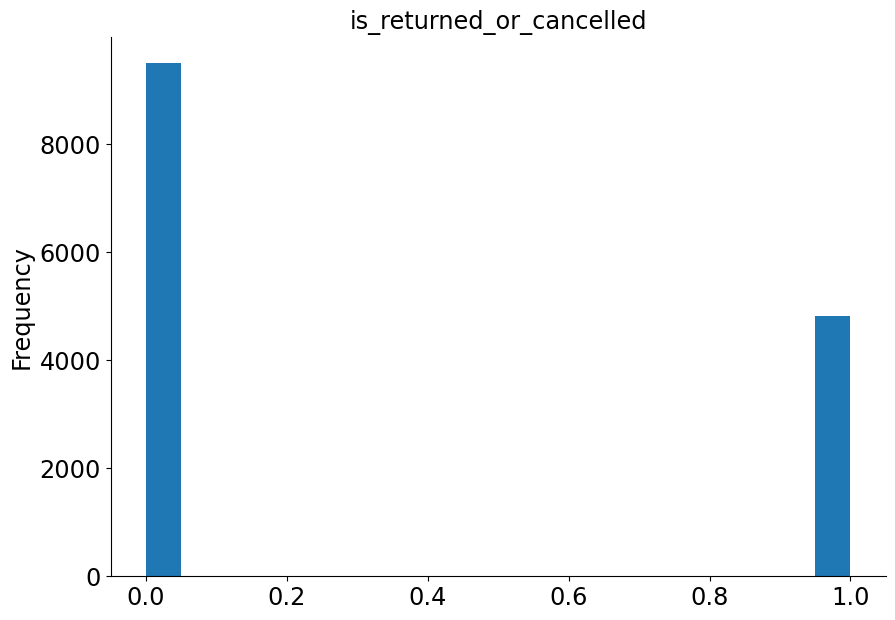

In [5]:
# @title is_returned_or_cancelled

from matplotlib import pyplot as plt
df['is_returned_or_cancelled'].plot(kind='hist', bins=20, title='is_returned_or_cancelled')
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-6-7870dd062363>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='age', y='gender', inner='box', palette='Dark2')


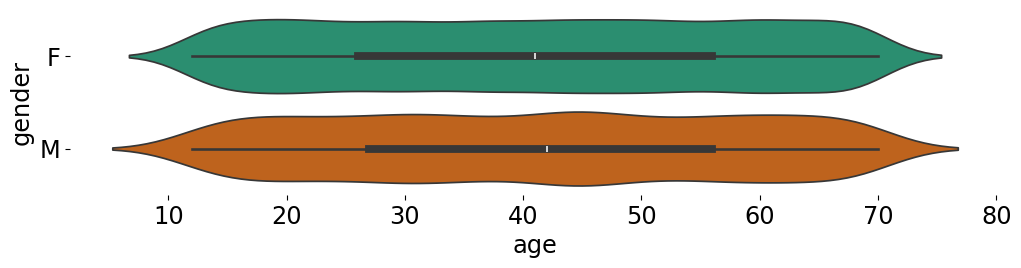

In [6]:
# @title gender vs age

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='age', y='gender', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## EDA

   user_id first_name  last_name                        email  age gender  \
0        1      Robin    Garrett     robingarrett@example.com   60      F   
1        8   Kimberly    Hawkins  kimberlyhawkins@example.net   62      F   
2       18      Susan  Dominguez   susandominguez@example.org   30      F   
3       20      David     Watson      davidwatson@example.org   35      M   
4       28      Donna    Vazquez     donnavazquez@example.com   69      F   

               state              street_address postal_code       city  \
0            England           351 Simon Landing          L9  Liverpool   
1          Guangdong             721 Smith Trail      518114    Dandong   
2        Connecticut  973 Santos Groves Apt. 414        6708  Waterbury   
3              Bahia           917 Fuller Forges   46400-000    Caetité   
4  Baden-Württemberg            2643 Reed Shores       70378  Stuttgart   

          country traffic_source  is_returned_or_cancelled  avg_num_of_item  \
0  Unit

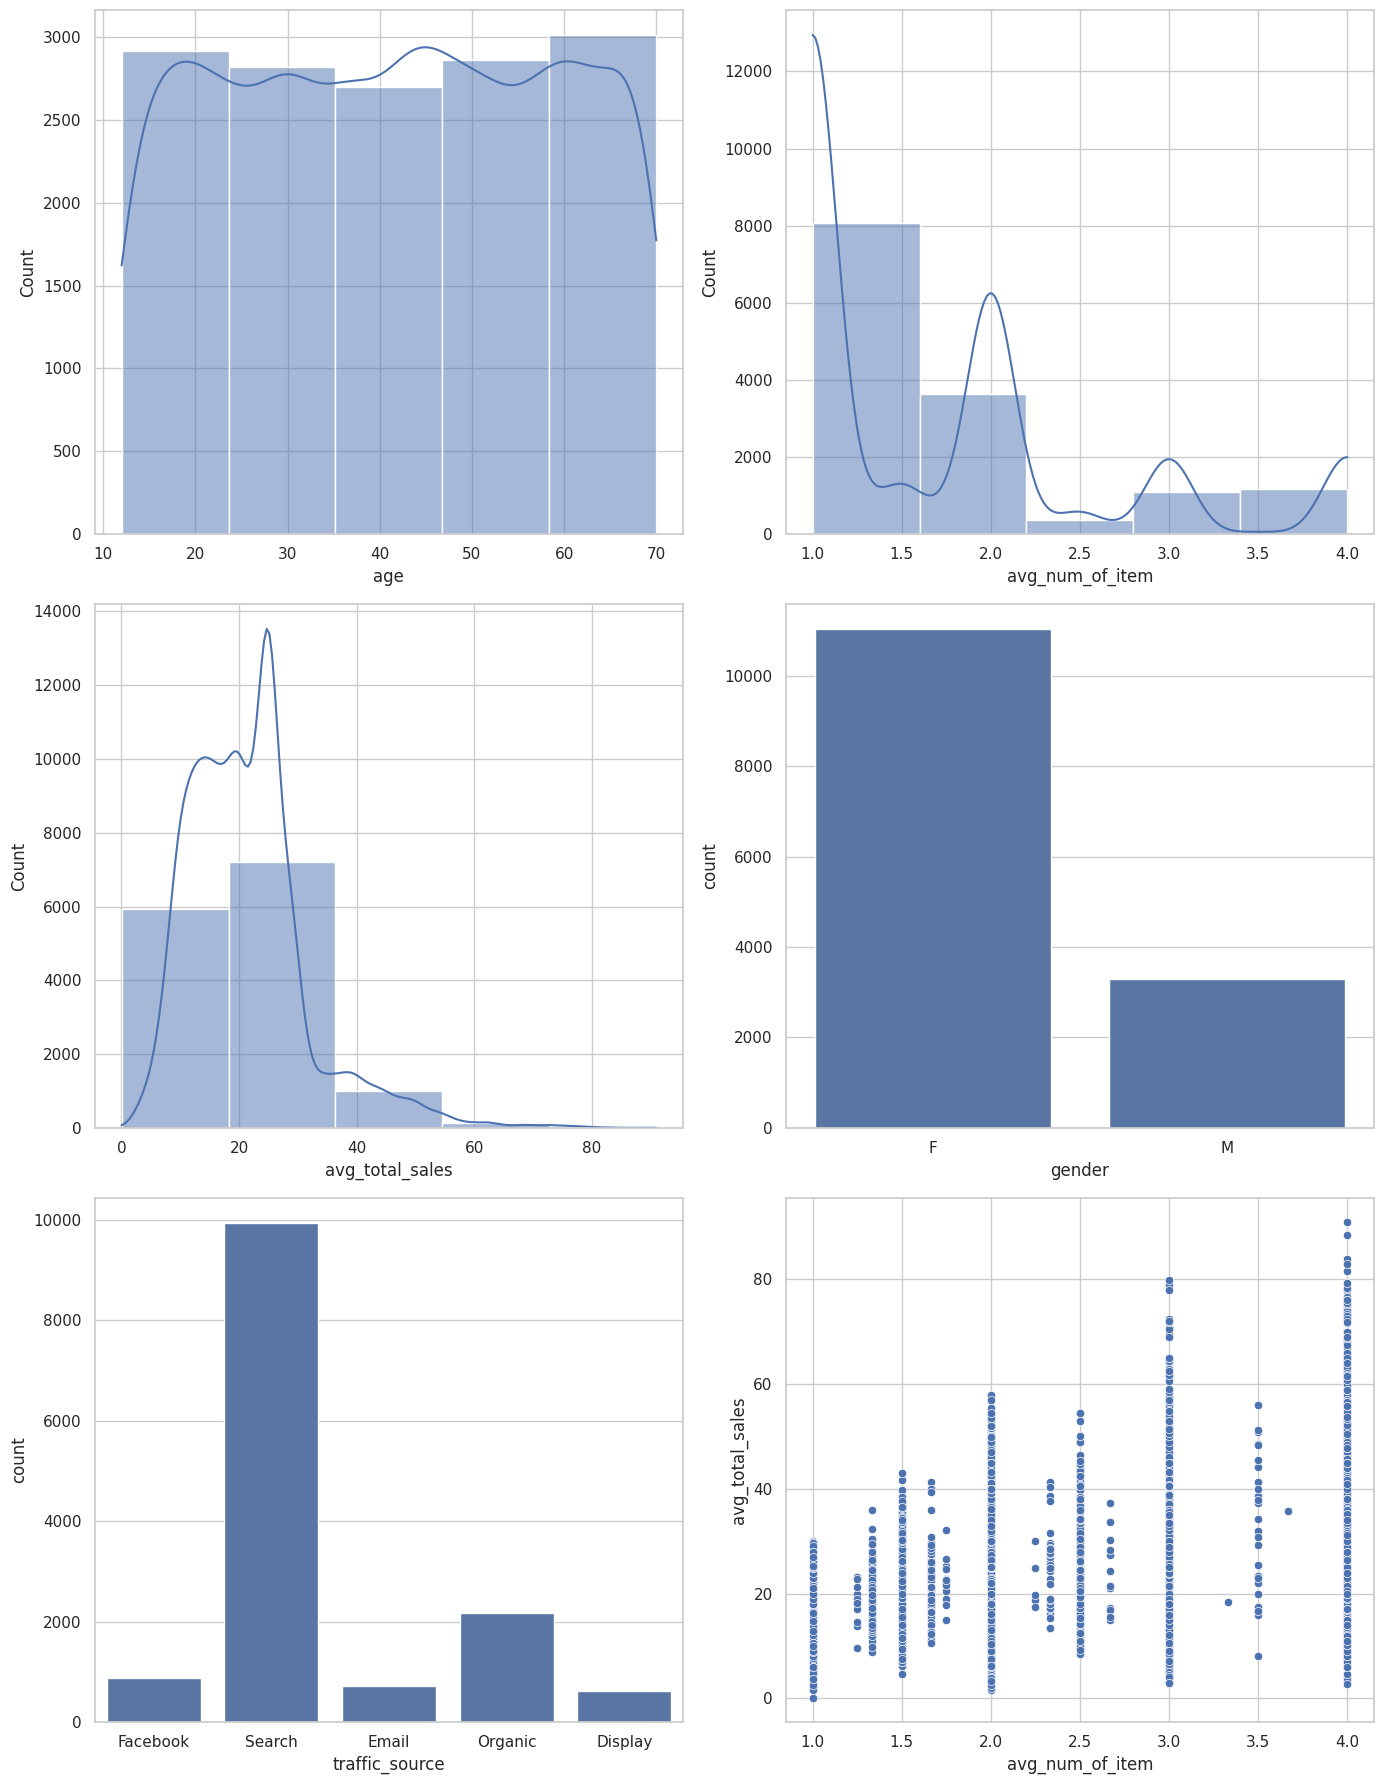

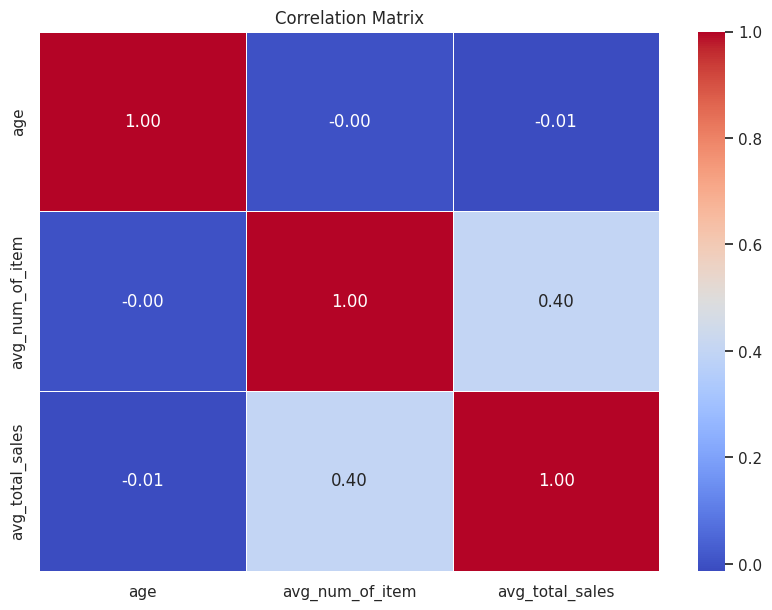

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Display basic info and descriptive statistics
print(df.head())
print(df.info())
print(df.describe(include='all'))

# Setting up the plotting environment
sns.set(style="whitegrid")

# Visualizations
fig, ax = plt.subplots(3, 2, figsize=(14, 18))
sns.histplot(df['age'], bins=5, kde=True, ax=ax[0, 0])
sns.histplot(df['avg_num_of_item'], bins=5, kde=True, ax=ax[0, 1])
sns.histplot(df['avg_total_sales'], bins=5, kde=True, ax=ax[1, 0])
sns.countplot(x='gender', data=df, ax=ax[1, 1])
sns.countplot(x='traffic_source', data=df, ax=ax[2, 0])
sns.scatterplot(x='avg_num_of_item', y='avg_total_sales', data=df, ax=ax[2, 1])
plt.tight_layout()
plt.show()

# Correlation matrix
correlation_matrix = df[['age', 'avg_num_of_item', 'avg_total_sales']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()


## Trening

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop('is_returned_or_cancelled', axis=1)
y = df['is_returned_or_cancelled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Creating transformers
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# Setting up ColumnTransformer
transform_var = ColumnTransformer(
    transformers=[
        ('num', num_transformer, ['age', 'avg_num_of_item', 'avg_total_sales']),
        ('cat', cat_transformer, ['user_id', 'first_name', 'last_name', 'email', 'gender',
                                  'state', 'street_address', 'postal_code', 'city', 'country',
                                  'traffic_source'])
    ])


In [10]:
X_train_transformed = transform_var.fit_transform(X_train)
X_test_transformed = transform_var.transform(X_test)

In [ ]:
model = FC_model(X_train_transformed.shape[1], X_train_transformed.toarray(), y_train, X_test_transformed.toarray(), y_test)

Sieć się wysyca juz po 1 epoce - accuracy i loss sie nie zmieniaja w nastepnych epokach - podobne obserwacje są po zmianie architketury sieci np dodając więcej warstw ukrytych czy zwiekszając liczbe neuronow w konretnyvh warstwach - obserwacje po kilkunastu przeprowadzonych treningach. Zamieszczam jedna z prostrzych aritektur sieci, cięzo coś więcej wyciągnąć z tych danych.

In [14]:
accuracy_train = model.evaluate(X_train_transformed.toarray(), y_train)
print('Dokładność: %.2f' % (accuracy_train[1]*100))

358/358 [==============================] - 4s 9ms/step - loss: 0.6534 - Accuracy: 0.6631 - false_positives: 0.0000e+00
Dokładność: 66.31


In [15]:
X_test_transformed_dense = X_test_transformed.toarray()
accuracy_test = model.evaluate(X_test_transformed_dense, y_test)
print('Dokładność: %.2f' % (accuracy_test[1]*100))

90/90 [==============================] - 1s 8ms/step - loss: 0.6537 - Accuracy: 0.6648 - false_positives: 0.0000e+00
Dokładność: 66.48


In [51]:
y_pred_s2 = model.predict(X_test_transformed_dense)
y_pred_class_s2 = (y_pred_s2 > 0.347).astype(int)

90/90 [==============================] - 1s 8ms/step


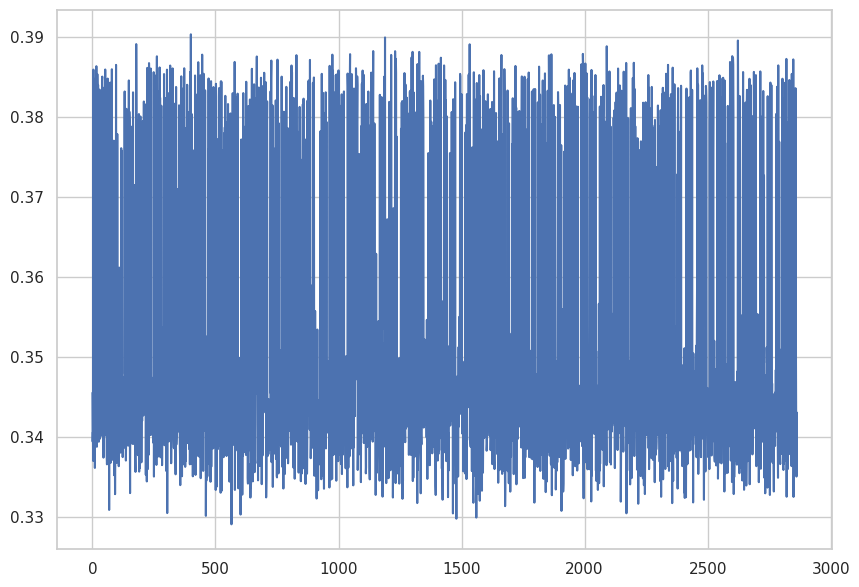

In [29]:
plt.plot(y_pred_s2)

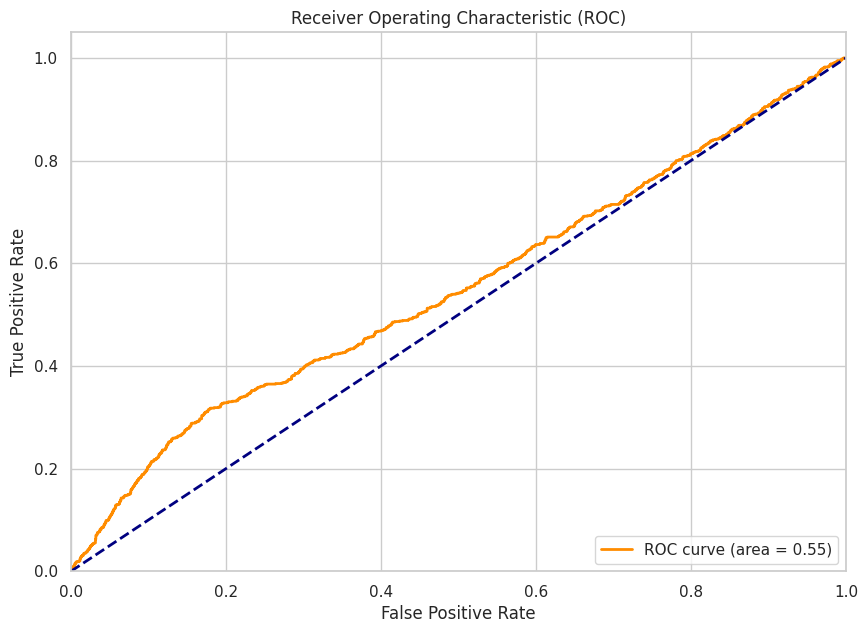

In [56]:
# Wyznaczanie krzywej ROC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, f1_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_s2)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Krzywa ROC ma słabe wskazania bliskie losowaniu.

In [55]:
# Obliczenie wartości F1
# F1=2x(precyzja*czułość/precyzja+czułość)
f1 = f1_score(y_test, y_pred_class_s2)
print("Wartość F1:", f1)

Wartość F1: 0.40078392944634983


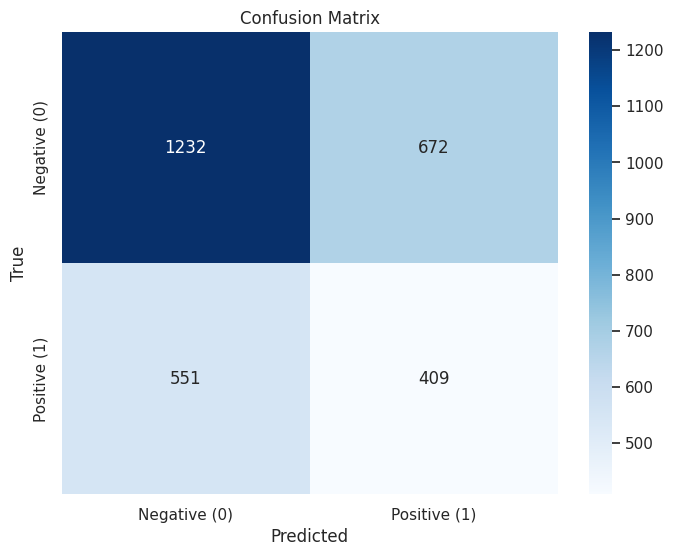

In [52]:
# Wygenerowanie macierzy pomyłek z etykietami
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred_class_s2, labels=[0, 1])

# Definicja etykiet klas
class_labels = ['Negative (0)', 'Positive (1)']

# Wyświetlenie macierzy pomyłek z opisami
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Gubimy najwięcej pozytywnych przypadków, w miarę dobrze sieć radzi sobie z klasyfikacją negatywnych.

Co mozna zrobic, aby wyniki były lepsze:
- więcej danych
- zmienić model - sieci w pełni połączone nie radzą sobie idealnie z tekstem 